In [2]:
#Preliminaries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import linear_model
from sklearn import ensemble
#pd.set_option('display.max_columns', None) #show all columns in the dataframe

c:\users\thyne\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
#DATA SETUP - PANDAS
#read the CSV into a pandas dataframe
df = pd.read_excel("259_finalproject_data.xlsx")
df2 = df.loc[:, ['Global_id', 'comment_index', 'comment_text', 'reply_index', 'FLAG_ABTRIATION', 'Final_Label']].rename({'FLAG_ABTRIATION': 'flag_resolution'}, axis=1)

In [5]:
df2.isnull().sum()

Global_id          0
comment_index      0
comment_text       0
reply_index        0
flag_resolution    0
Final_Label        0
dtype: int64

In [6]:
df2.describe()

,Global_id,comment_index,reply_index,flag_resolution,Final_Label
count,599.000000,599.000000,599.000000,599.000000,599.000000
mean,299.000000,59.415693,1.996661,0.212020,0.076795
std,173.060683,34.636080,1.414210,0.487423,0.266488
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,149.500000,29.500000,1.000000,0.000000,0.000000
50%,299.000000,59.000000,2.000000,0.000000,0.000000
75%,448.500000,89.000000,3.000000,0.000000,0.000000
max,598.000000,119.000000,4.000000,2.000000,1.000000


- 7.7% inflammatory "replies"
- 21% needed resolution

In [7]:
df2.head(15)

,Global_id,comment_index,comment_text,reply_index,flag_resolution,Final_Label
0,0,0,"I was in the Navy, and I used to take smoke br...",0,0,0
1,1,0,"I was in the Navy, and I used to take smoke br...",1,0,0
2,2,0,"I was in the Navy, and I used to take smoke br...",2,0,0
3,3,0,"I was in the Navy, and I used to take smoke br...",3,0,0
4,4,0,"I was in the Navy, and I used to take smoke br...",4,0,0
5,5,1,">""One of our non-smoking staff put a message i...",0,0,0
6,6,1,">""One of our non-smoking staff put a message i...",1,0,0
7,7,1,">""One of our non-smoking staff put a message i...",2,0,0
8,8,1,">""One of our non-smoking staff put a message i...",3,0,0
9,9,1,">""One of our non-smoking staff put a message i...",4,0,0


In [8]:
dfc =df2.groupby('comment_index').agg({'comment_text':'first', 'Final_Label': 'sum'})
dfc = dfc.rename(columns ={'Final_Label':'Comment Score'}).reset_index()

In [9]:
dfc.head()

,comment_index,comment_text,Comment Score
0,0,"I was in the Navy, and I used to take smoke br...",0
1,1,">""One of our non-smoking staff put a message i...",0
2,2,One of my best friends had never smoked before...,0
3,3,Positive reinforcement is effective. I wish mo...,0
4,4,"When I used to smoke, I'd do it at 10 o'clock ...",0


In [10]:
dfc.describe()

,comment_index,Comment Score
count,120.000000,120.000000
mean,59.500000,0.383333
std,34.785054,0.712238
min,0.000000,0.000000
25%,29.750000,0.000000
50%,59.500000,0.000000
75%,89.250000,1.000000
max,119.000000,4.000000


(array([86., 25.,  7.,  1.,  1.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <a list of 5 Patch objects>)

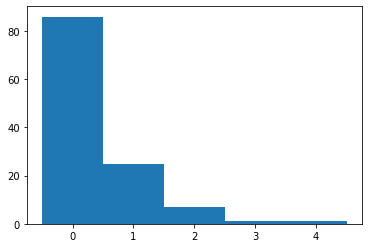

In [11]:
plt.hist(dfc['Comment Score'], bins=[-0.5,0.5, 1.5,2.5,3.5,4.5])

- mean score: 0.383
- max : 4
- top 25%: still a score of 1

## Splitting the Data: Dealing with Imbalanced Data

Oversampling comments with scores greater than 0

In [12]:
y = dfc[['Comment Score']]
X = dfc.drop('Comment Score', axis =1)
#Split the dataset, stratify on y values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state =42)

In [13]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

print(X['Comment Score'].value_counts())

# separate minority and majority classes
ninf = X[X['Comment Score']==0]
inf = X[X['Comment Score']!= 0] #every other score

# upsample minority
inf_upsampled = resample(inf,
                          replace=True, # sample with replacement
                          n_samples=len(ninf), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([ninf, inf_upsampled])

# check new class counts
upsampled['Comment Score'].value_counts()


0    65
1    17
2     6
4     1
3     1
Name: Comment Score, dtype: int64


0    65
1    46
2    15
4     3
3     1
Name: Comment Score, dtype: int64

In [14]:
#recreate X, y training set
y_train = upsampled[['Comment Score']]
X_train = upsampled.drop('Comment Score', axis =1)

In [23]:
y_train['Comment Score'].unique()

array([0, 1, 4, 2, 3], dtype=int64)

In [192]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(comment):
    comment = comment.lower()
    score = analyser.polarity_scores(comment)
    return(score)

def getNegScore(comment):
    comment = comment.lower()
    return(analyser.polarity_scores(comment)['neg'])

def getPosScore(comment):
    comment = comment.lower()
    return(analyser.polarity_scores(comment)['pos'])

def getNeuScore(comment):
    comment = comment.lower()
    return(analyser.polarity_scores(comment)['neu'])
    
def getNumSwears(comment):
    comment = comment.lower()
    swearList = ["ass", "arse", "bastard", "bitch", "crap", "cunt", "damn", "fuck", "hell", "nigga", "nigger", "prick", "shit", "slut", "whore", "twat"]
    count = 0
    for s in swearList:
        if s in comment:
            count += 1
    return(count)

def getNumYou(comment):
    comment = comment.lower()
    count = 0
    words = comment.split(" ")
    for w in words:
        if "you" in w:
            count += 1
    return(count)

def hasEdit(comment):
    comment = comment.lower()
    if "edit" in comment:
        return(1)
    else:
        return(0)
    
def hasThanks(comment):
    comment = comment.lower()
    if "thank" in comment:
        return(1)
    return(0)

def hasLikeLove(comment):
    comment = comment.lower()
    if "like" in comment or "love" in comment:
        return(1)
    return(0)

def hasPlease(comment):
    comment = comment.lower()
    if "please" in comment:
        return(1)
    return(0)

def numLaugh(comment):
    comment = comment.lower()
    laughList = ['haha', 'ha ', ' ha.', 'lol', 'lmao', 'lmfao', ' lul ', 'lul ', 'hehe']
    count = 0
    for l in laughList:
        if l in comment:
            count += 1
    return(count)


In [193]:
getNeuScore('this is a test')

1.0

In [194]:
X_train['comment_num_swears'] = X_train["comment_text"].apply(getNumSwears)
X_train['comment_num_you'] = X_train["comment_text"].apply(getNumYou)
X_train['comment_has_edit'] = X_train["comment_text"].apply(hasEdit)
X_train['comment_has_thanks'] = X_train["comment_text"].apply(hasThanks)
X_train['comment_has_likelove'] = X_train["comment_text"].apply(hasLikeLove)
X_train['comment_has_please'] = X_train["comment_text"].apply(hasPlease)
X_train['comment_num_laughs'] = X_train["comment_text"].apply(numLaugh)
X_train['comment_neg_score'] = X_train["comment_text"].apply(getNegScore)
X_train['comment_pos_score'] = X_train["comment_text"].apply(getPosScore)
X_train['comment_neu_score'] = X_train["comment_text"].apply(getNeuScore)

X_test['comment_num_swears'] = X_test["comment_text"].apply(getNumSwears)
X_test['comment_num_you'] = X_test["comment_text"].apply(getNumYou)
X_test['comment_has_edit'] = X_test["comment_text"].apply(hasEdit)
X_test['comment_has_thanks'] = X_test["comment_text"].apply(hasThanks)
X_test['comment_has_likelove'] = X_test["comment_text"].apply(hasLikeLove)
X_test['comment_has_please'] = X_test["comment_text"].apply(hasPlease)
X_test['comment_num_laughs'] = X_test["comment_text"].apply(numLaugh)
X_test['comment_neg_score'] = X_test["comment_text"].apply(getNegScore)
X_test['comment_pos_score'] = X_test["comment_text"].apply(getPosScore)
X_test['comment_neu_score'] = X_test["comment_text"].apply(getNeuScore)

In [195]:
def textToMatrix(comment):
    featureMatrix = []
    featureMatrix.append(getNumSwears(comment))
    featureMatrix.append(getNumYou(comment))
    featureMatrix.append(hasEdit(comment))
    featureMatrix.append(hasThanks(comment))
    featureMatrix.append(hasLikeLove(comment))
    featureMatrix.append(hasPlease(comment))
    featureMatrix.append(numLaugh(comment))
    featureMatrix.append(getNegScore(comment))
    featureMatrix.append(getPosScore(comment))
    featureMatrix.append(getNeuScore(comment))

    return([featureMatrix])

In [196]:
from sklearn.linear_model import LinearRegression
import numpy as np

In [294]:
def trainLinReg(train_feat, train_score, test_feat, test_score):
    if 'comment_index' in train_feat.columns and 'comment_text' in train_feat.columns:
        trainFeatures = train_feat.drop(['comment_index', 'comment_text'], axis = 1)
    else: 
        trainFeatures = train_feat
    if 'comment_index' in test_feat.columns and 'comment_text' in test_feat.columns:
        testFeatures = test_feat.drop(['comment_index', 'comment_text'], axis = 1)
    else:
        testFeatures = test_feat

    trainFeatMatrix = trainFeatures.to_numpy()
    trainLabelMatrix = train_score['Comment Score'].to_numpy()

    testFeatMatrix = testFeatures.to_numpy()
    testLabelMatrix = test_score['Comment Score'].to_numpy()
    
    lin_reg = LinearRegression().fit(trainFeatMatrix, trainLabelMatrix)
    pred = lin_reg.predict(testFeatMatrix)
    
    MSE = sum(pow(testLabelMatrix-pred,2))
    baselinePred = np.full(pred.shape[0], train_score['Comment Score'].describe()['mean'])
    baselineMSE = sum(pow(testLabelMatrix-baselinePred,2))
    
    return(lin_reg, pred, MSE, baselineMSE)

In [295]:
lin_model, lin_pred, lin_MSE, lin_baselineMSE = trainLinReg(X_train, y_train, X_test, y_test)
lin_MSE, lin_baselineMSE

(13.26399527011446, 12.700000000000001)

In [268]:
from sklearn.ensemble import RandomForestRegressor

def trainRFReg(train_feat, train_score, test_feat, test_score):
    if 'comment_index' in train_feat.columns and 'comment_text' in train_feat.columns:
        trainFeatures = train_feat.drop(['comment_index', 'comment_text'], axis = 1)
    else: 
        trainFeatures = train_feat
    if 'comment_index' in test_feat.columns and 'comment_text' in test_feat.columns:
        testFeatures = test_feat.drop(['comment_index', 'comment_text'], axis = 1)
    else:
        testFeatures = test_feat

    trainFeatMatrix = trainFeatures.to_numpy()
    print(trainFeatMatrix[0])
    trainLabelMatrix = train_score['Comment Score'].to_numpy()

    testFeatMatrix = testFeatures.to_numpy()
    testLabelMatrix = test_score['Comment Score'].to_numpy()
    
    rf_reg = RandomForestRegressor(max_depth = 3)
    rf_reg.fit(trainFeatMatrix, trainLabelMatrix)
    pred = rf_reg.predict(testFeatMatrix)
    
    MSE = sum(pow(testLabelMatrix-pred,2))
    baselinePred = np.full(pred.shape[0], train_score['Comment Score'].describe()['mean'])
    baselineMSE = sum(pow(testLabelMatrix-baselinePred,2))
    
    return(rf_reg, pred, MSE, baselineMSE)

In [275]:
rf_model, rf_pred, rf_MSE, rf_baselineMSE = trainRFReg(X_train, y_train, X_test, y_test)
rf_MSE, rf_baselineMSE

[0.    0.    0.    0.    0.    0.    0.    0.111 0.092 0.797]


(8.353174587097815, 12.700000000000001)

In [270]:
y_train['Comment Score'].describe()['mean']

0.7

In [271]:
rf_model.feature_importances_

array([0.02015891, 0.        , 0.07628436, 0.04799211, 0.21178752,
       0.        , 0.00773203, 0.18669404, 0.0958575 , 0.35349353])

In [272]:
inflammatoryComment = textToMatrix('you suck man, no one wants to hear from you')
rf_model.predict(inflammatoryComment)

array([1.32971317])

In [260]:
niceComment = textToMatrix('that is cool, thanks for sharing!')
rf_model.predict(niceComment)

array([0.42395833])

In [261]:
y_train.describe()

,Comment Score
count,130.000000
mean,0.700000
std,0.877364
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,4.000000


In [262]:
X_train2 = pd.DataFrame()
X_test2 = pd.DataFrame()

X_train2['comment_num_swears'] = X_train["comment_text"].apply(getNumSwears)
X_train2['comment_num_you'] = X_train["comment_text"].apply(getNumYou)
X_train2['comment_has_edit'] = X_train["comment_text"].apply(hasEdit)
X_train2['comment_has_likelove'] = X_train["comment_text"].apply(hasLikeLove)
X_train2['comment_neg_score'] = X_train["comment_text"].apply(getNegScore)
X_train2['comment_pos_score'] = X_train["comment_text"].apply(getPosScore)
X_train2['comment_neu_score'] = X_train["comment_text"].apply(getNeuScore)

X_test2['comment_num_swears'] = X_test["comment_text"].apply(getNumSwears)
X_test2['comment_num_you'] = X_test["comment_text"].apply(getNumYou)
X_test2['comment_has_edit'] = X_test["comment_text"].apply(hasEdit)
X_test2['comment_has_likelove'] = X_test["comment_text"].apply(hasLikeLove)
X_test2['comment_neg_score'] = X_test["comment_text"].apply(getNegScore)
X_test2['comment_pos_score'] = X_test["comment_text"].apply(getPosScore)
X_test2['comment_neu_score'] = X_test["comment_text"].apply(getNeuScore)

In [287]:
rf_model2, rf_pred2, rf_MSE2, rf_baselineMSE2 = trainRFReg(X_train2, y_train, X_test2, y_test)
rf_MSE2, rf_baselineMSE2

[0.    0.    0.    0.    0.111 0.092 0.797]


(9.101340910056262, 12.700000000000001)

In [296]:
lin_model2, lin_pred2, lin_MSE2, lin_baselineMSE2 = trainLinReg(X_train2, y_train, X_test2, y_test)
lin_MSE2, lin_baselineMSE2

(11.931207077352289, 12.700000000000001)

In [288]:
rf_model2.feature_importances_

array([0.01436947, 0.01757879, 0.05209148, 0.13281248, 0.22941988,
       0.2549314 , 0.29879651])

In [290]:
inflammatoryComment = textToMatrix("your opinion sucks, stop posting on this site asshole")
rf_model.predict(inflammatoryComment)

array([1.43341626])

In [291]:
niceComment = textToMatrix("thats so cool! thanks for posting")
rf_model.predict(niceComment)

array([0.31929478])

In [292]:
neutralComment = textToMatrix("I'm not sure about that, I would have too look it up")
rf_model.predict(neutralComment)

array([0.3635978])